In [1]:
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigs
import matplotlib.pyplot as plt
import timeit
import networkx as nx
import rmt
import imp
imp.reload(rmt)

<module 'rmt' from '/Users/zack/Documents/rmtchem/rmt.py'>

Calculated  100  eigenvalues for matrix with sparsity  0.05  in  0.16436192700030006 seconds


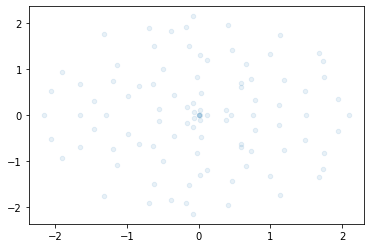

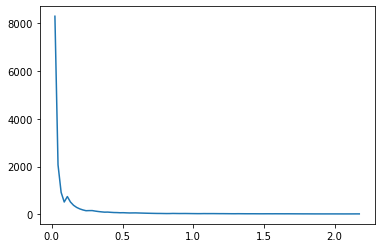

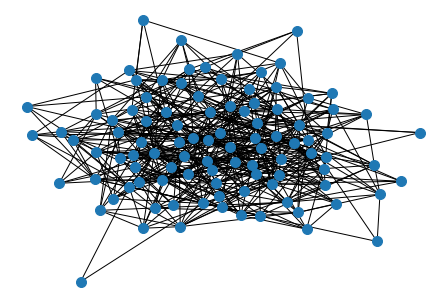

In [12]:
n=100
c=5
start=timeit.default_timer()
A=rmt.regular(n, c, 0, 1)
A=rmt.erdos(n, c, 0, 1)
evals,evecs=np.linalg.eig(A)
stop=timeit.default_timer()
print("Calculated ", n, " eigenvalues for matrix with sparsity ", c/n, " in ", stop-start, "seconds")
plt.scatter(np.real(evals),np.imag(evals), 2*len(evals)**0.5, alpha=0.1)
plt.show()
steps=100
vals=np.array([k/steps*np.max(np.abs(evals)) for k in range(1,steps)])
num=np.array([len(np.where(np.abs(evals)<k/steps*np.max(np.abs(evals)))[0]) for k in range(1,steps)])
plt.plot(vals,num/(vals*vals))
plt.show()
rows,cols=np.where(A!=0)
edges = zip(rows, cols)
gr = nx.Graph()
gr.add_edges_from(edges)
nx.draw(gr, node_size=100)

The resolvant G of A can be found from elements of the inverse of a Hermitian matrix B. The resolvant has poles at the eigenvalues. This is regularized form with small $\eta$ which is invertible everywhere at tends to G as $\eta \to 0^+$

1.350864907


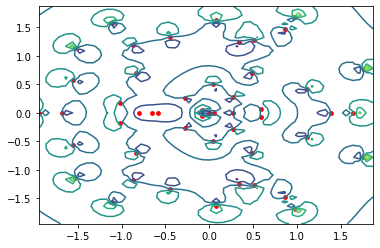

In [3]:
start=timeit.default_timer()
points=50
eta=1e-2
mval=np.max(np.abs(evals))
x=[[zr for zr in np.arange(-mval,mval, 2*mval/points)] for zi in np.arange(-mval,mval, 2*mval/points)]
y=[[zi for zr in np.arange(-mval,mval, 2*mval/points)] for zi in np.arange(-mval,mval, 2*mval/points)]
vals=[[np.trace(rmt.G(A,zr+1j*zi,eta)) for zr in np.arange(-mval,mval, 2*mval/points)] for zi in np.arange(-mval,mval,2*mval/points)]
stop=timeit.default_timer()
print(stop-start)

plt.contour(x,y,np.abs(vals))
plt.scatter(np.real(evals),np.imag(evals), 2*len(evals)**0.5, 'red')
plt.show()

We can verify the recursive equations directly. Here we test Eq. 60 for z=evals[0].

In [13]:
z=evals[0]
eta=1e-2
start=timeit.default_timer()
g1=rmt.g(A,z,eta)
stop=timeit.default_timer()
print(stop-start)

start=timeit.default_timer()
g2=rmt.gr(A,z,eta)
stop=timeit.default_timer()
print(stop-start)

start=timeit.default_timer()
A2=np.array([[[[0,A[j,k]],[A[k,j].conjugate(),0]] for k in range(n)] for j in range(n)])
Z=np.array([[0,z],[z.conjugate(),0]])
esum=np.einsum('jion,nmikj,kjml->jol', A2,g2, A2)
test60=np.array([np.linalg.inv(Z-1j*eta*np.array([[1,0],[0,1]])-A2[j,j]-esum[j]) for j in range(n)])
stop=timeit.default_timer()
print(stop-start)

print(np.linalg.norm([np.linalg.norm(test60[j]-g1[:,:,j,j]) for j in range(n)]))

0.00408357399965098
0.3072617210000317
1.184554715000104
4.308127940570028e-13


In [9]:
filebase='data/test'
Zs=np.load(filebase+'Z.npy')
g1s=np.load(filebase+'g.npy')
g2s=np.load(filebase+'gr.npy')
A=np.load(filebase+'mat.npy')
n=len(A)
j=24
z=zs[j]
g1=g1s[j]
g2=g2s[j]
Z=Zs[j]

start=timeit.default_timer()
A2=np.array([[[[0,A[j,k]],[A[k,j].conjugate(),0]] for k in range(n)] for j in range(n)])
esum=np.einsum('jion,nmikj,kjml->jol', A2,g2, A2)
test60=np.array([np.linalg.inv(Z-A2[j,j]-esum[j]) for j in range(n)])
stop=timeit.default_timer()
print(stop-start)

print(np.linalg.norm([np.linalg.norm(test60[j]-g1[:,:,j,j]) for j in range(n)]))

1.025245047999988
1.7882682590090902e-14


In going from 60 to 62, it is assumed the graph is tree-like so off-diagonal components of the sum are negligible. For the regular and erdos-renyi random graphs, they are not

In [5]:
start=timeit.default_timer()
esum3=np.einsum('jion,nmikj,kjml->ikjol', A2, g2, A2)
stop=timeit.default_timer()
print(stop-start)

print(np.linalg.norm(esum-np.sum(esum3,axis=(0,1))))
print(np.linalg.norm(esum))
print(np.linalg.norm(esum-np.sum(np.diagonal(esum3,axis1=0,axis2=1),axis=3)))

0.12097152299999436
0.0
46.13887825257095
45.62591749756173
